# Logit Lens

## Introduction

🔍 Logit Lens is a powerful tool that grants us a simplified (yet insightful) understanding of the inner workings of transformer models.

We can estimate the model's guess for the output after each computational step by applying a softmax function to each layer's output. Unlike traditional approaches focusing on *how* beliefs are updated within a step, with Logit Lens we gain a glimpse into *what* output the model is predicting at each processing step.

📗 Read more about Logit Lens from nostalgebraist’s blog post on LessWrong, [here](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens)

💻 You can find a Colab version of our tutorial [here](https://colab.research.google.com/github/ndif-team/nnsight/blob/main/docs/source/notebooks/tutorials/logit_lens.ipynb), or nostalgebraist’s original code [here](https://colab.research.google.com/drive/1-nOE-Qyia3ElM17qrdoHAtGmLCPUZijg?usp=sharing)

## Setup

If using Colab, install NNsight:
```
!pip install -U nnsight
```

In [1]:
try:
    import google.colab
    is_colab = True
except ImportError:
    is_colab = False

if is_colab:
    !pip install -U nnsight

Import libraries and load GPT-2 model.

In [2]:
# Import libraries
from IPython.display import clear_output
from nnsight import LanguageModel
from typing import List, Callable
import torch
import numpy as np
from IPython.display import clear_output

clear_output()

In [3]:
# Load gpt2
model = LanguageModel("openai-community/gpt2", device_map="auto", dispatch=True)

## GPT-2 Model Architecture

Let's take a look at GPT-2's architecture. GPT-2 has 12 layers, accessed as `model.transformer.h`.

In [4]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
  (generator): Generator(
    (streamer): Streamer()
  )
)


## Apply Logit Lens



To apply logit lens, we collect activations at each layer's output, apply layer normalization (`model.transformer.ln_f`), and then process through the model's head (`model.lm_head`) to get the logits. Next, we apply the softmax to the logits to obtain output token probabilities.

By observing different layers' output token probabilities, logit lens provides insights into the model's confidence throughout processing steps.

In [5]:
prompt= "The Eiffel Tower is in the city of"
layers = model.transformer.h
probs_layers = []

with model.trace() as tracer:
    with tracer.invoke(prompt) as invoker:
      # store input tokens
      input_tokens = invoker.inputs.save()
      for layer_idx, layer in enumerate(layers):
          # Process layer output through the model's head and layer normalization
          layer_output = model.lm_head(model.transformer.ln_f(layer.output[0]))

          # Apply softmax to obtain probabilities and save the result
          probs = torch.nn.functional.softmax(layer_output, dim=-1).save()
          probs_layers.append(probs)

probs = torch.cat([probs for probs in probs_layers])

# Find the maximum probability and corresponding tokens for each position
max_probs, tokens = probs.max(dim=-1)

# Decode token IDs to words for each layer
words = [[model.tokenizer.decode(t.cpu()).encode("unicode_escape").decode() for t in layer_tokens]
    for layer_tokens in tokens]

# Access the 'input_ids' attribute of the invoker object to get the input words
input_words = [model.tokenizer.decode(t) for t in input_tokens[1]['input_ids'][0]]

## Visualizing GPT-2 Layer Interpretations

Now we will visualize the prediction of the GPT-2 model while processing the string *`'The Eiffel Tower is in the city of'`* and we’ll explore the interpretations of each layer within the GPT2Block, gaining insights into what each layer believes could be the next word for every input word.



python(68954) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


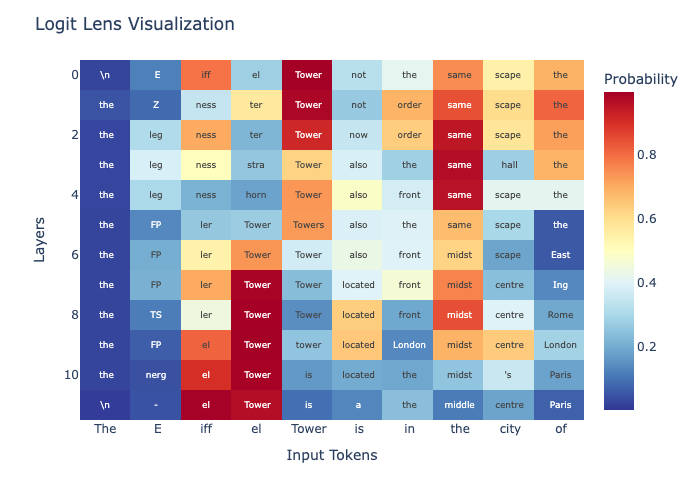

In [8]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "colab" if is_colab else "notebook_connected+plotly_mimetype+png"
# pio.renderers.default = "colab" if is_colab else "png"

fig = px.imshow(
    max_probs.detach().cpu().numpy(),
    x=input_words,
    y=list(range(len(words))),
    color_continuous_scale=px.colors.diverging.RdYlBu_r,
    color_continuous_midpoint=0.50,
    text_auto=True,
    labels=dict(x="Input Tokens", y="Layers", color="Probability")
)

fig.update_layout(
    title='Logit Lens Visualization',
    xaxis_tickangle=0
)

fig.update_traces(text=words, texttemplate="%{text}")
fig.show()

The vertical axis indexes the layers, zero-indexed from 0 to 11. The top guess for each token, according to the model’s activations at a given layer, is printed in each cell. The colors show the probability associated with the top guess.